# Sharp regression discontinuity with `pymc` models

In [1]:
import causalpy as cp

In [2]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
seed = 42

In [3]:
df = cp.load_data("rd")

## Linear, main-effects, and interaction model

:::{note}
The `random_seed` keyword argument for the PyMC sampler is not necessary. We use it here so that the results are reproducible.
:::

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
Sampling: [beta, sigma, y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]


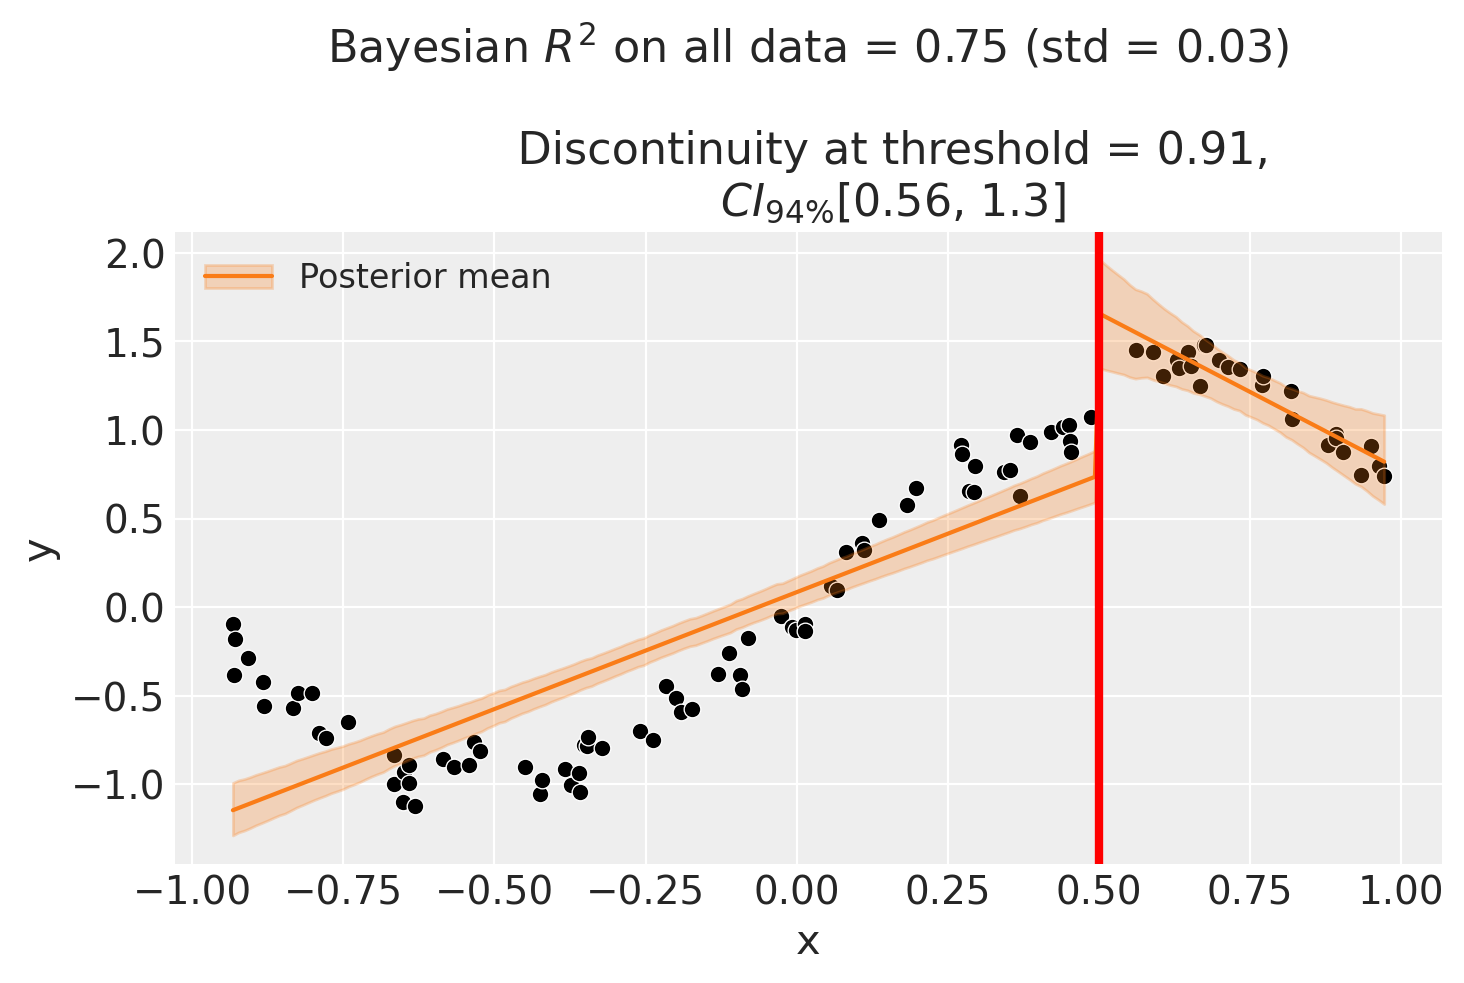

In [4]:
result = cp.RegressionDiscontinuity(
    df,
    formula="y ~ 1 + x + treated + x:treated",
    model=cp.pymc_models.LinearRegression(sample_kwargs={"random_seed": seed}),
    treatment_threshold=0.5,
)

fig, ax = result.plot()

Though we can see that this does not give a good fit of the data almost certainly overestimates the discontinuity at threshold.

## Using a bandwidth

One way how we could deal with this is to use the `bandwidth` kwarg. This will only fit the model to data within a certain bandwidth of the threshold. If $x$ is the running variable, then the model will only be fitted to data where $threshold - bandwidth \le x \le threshold + bandwidth$.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
Sampling: [beta, sigma, y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]


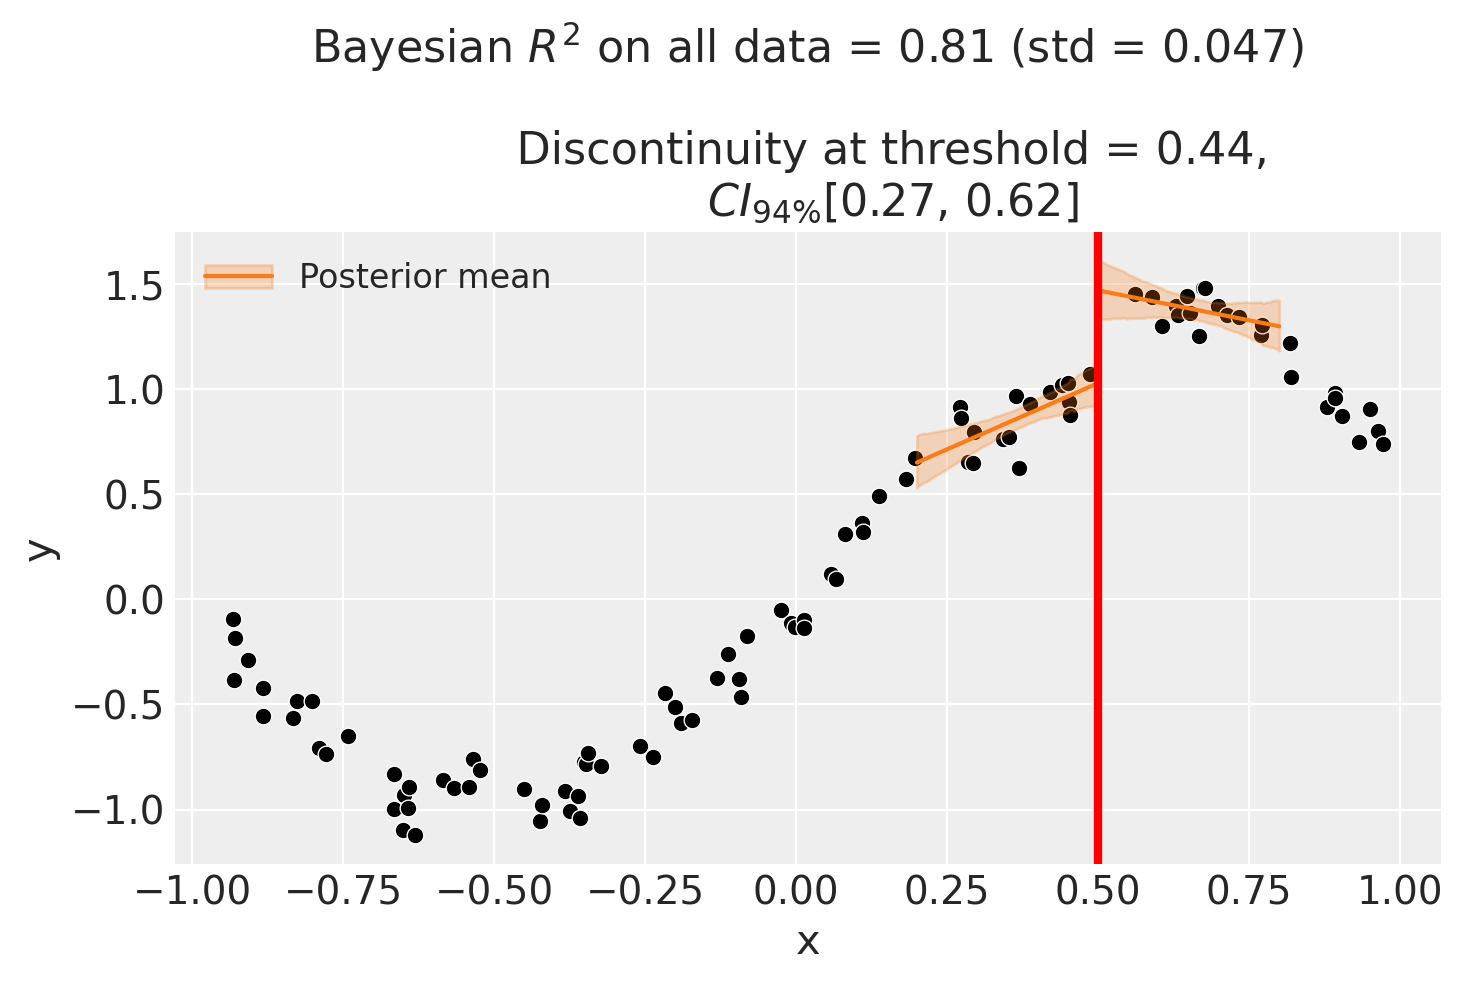

In [5]:
result = cp.RegressionDiscontinuity(
    df,
    formula="y ~ 1 + x + treated + x:treated",
    model=cp.pymc_models.LinearRegression(sample_kwargs={"random_seed": seed}),
    treatment_threshold=0.5,
    bandwidth=0.3,
)

fig, ax = result.plot()

We could even go crazy and just fit intercepts for the data close to the threshold. But clearly this will involve more estimation error as we are using less data.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Sampling: [beta, sigma, y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]


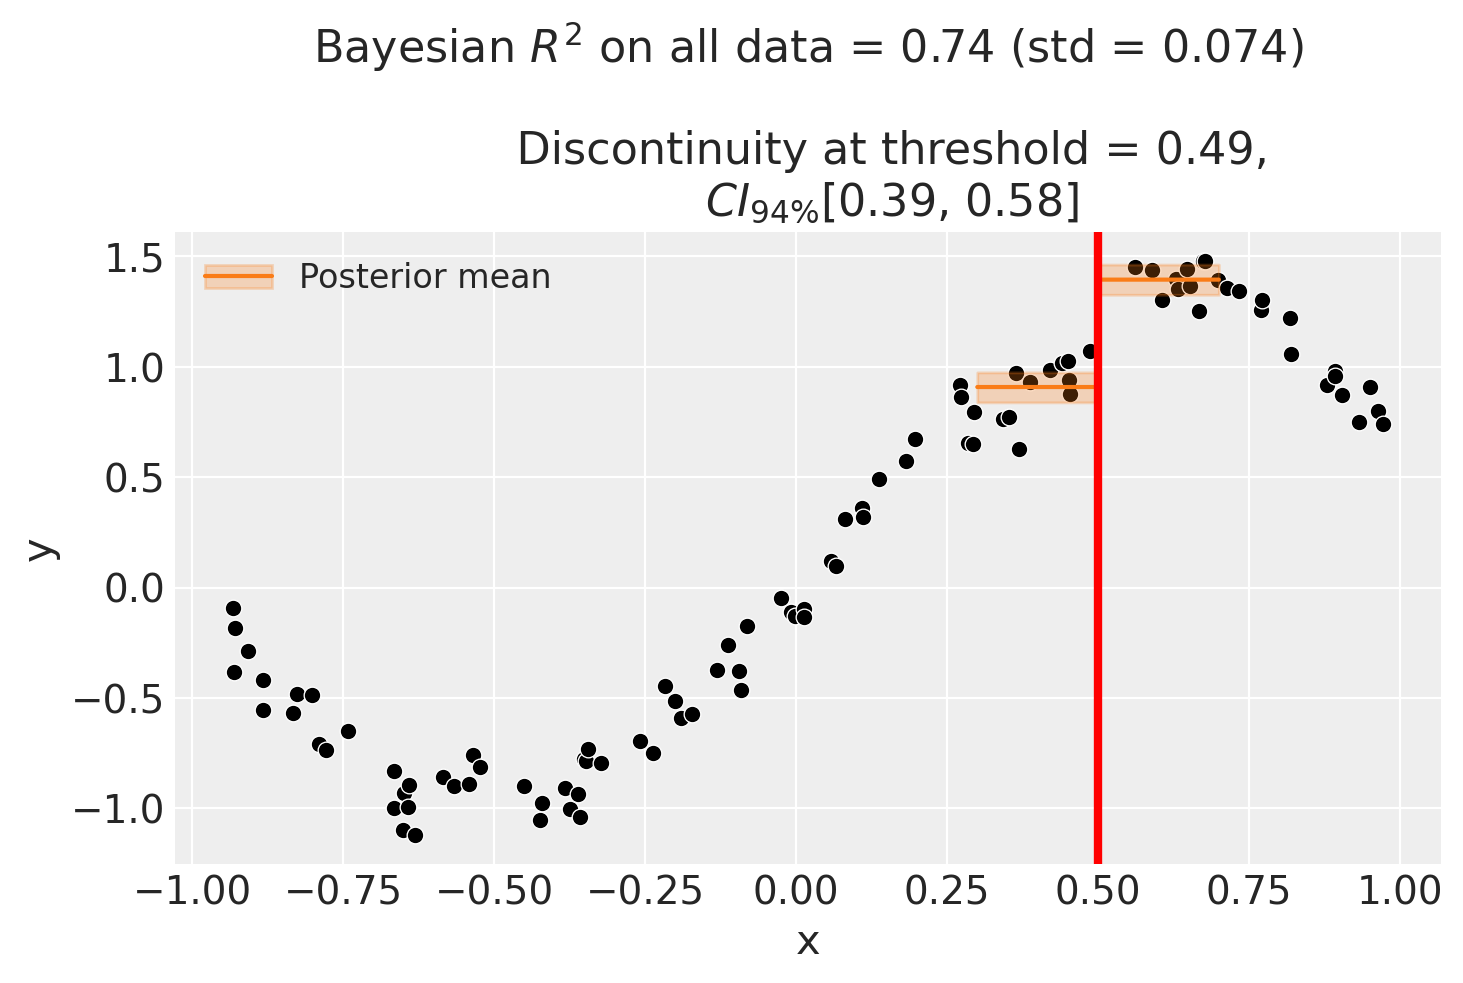

In [6]:
result = cp.RegressionDiscontinuity(
    df,
    formula="y ~ 1 + treated",
    model=cp.pymc_models.LinearRegression(sample_kwargs={"random_seed": seed}),
    treatment_threshold=0.5,
    bandwidth=0.2,
)

fig, ax = result.plot()

## Using basis splines

Though it could arguably be better to fit with a more complex model, fit example a spline. This allows us to use all of the data, and (depending on the situation) maybe give a better fit.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
Sampling: [beta, sigma, y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]


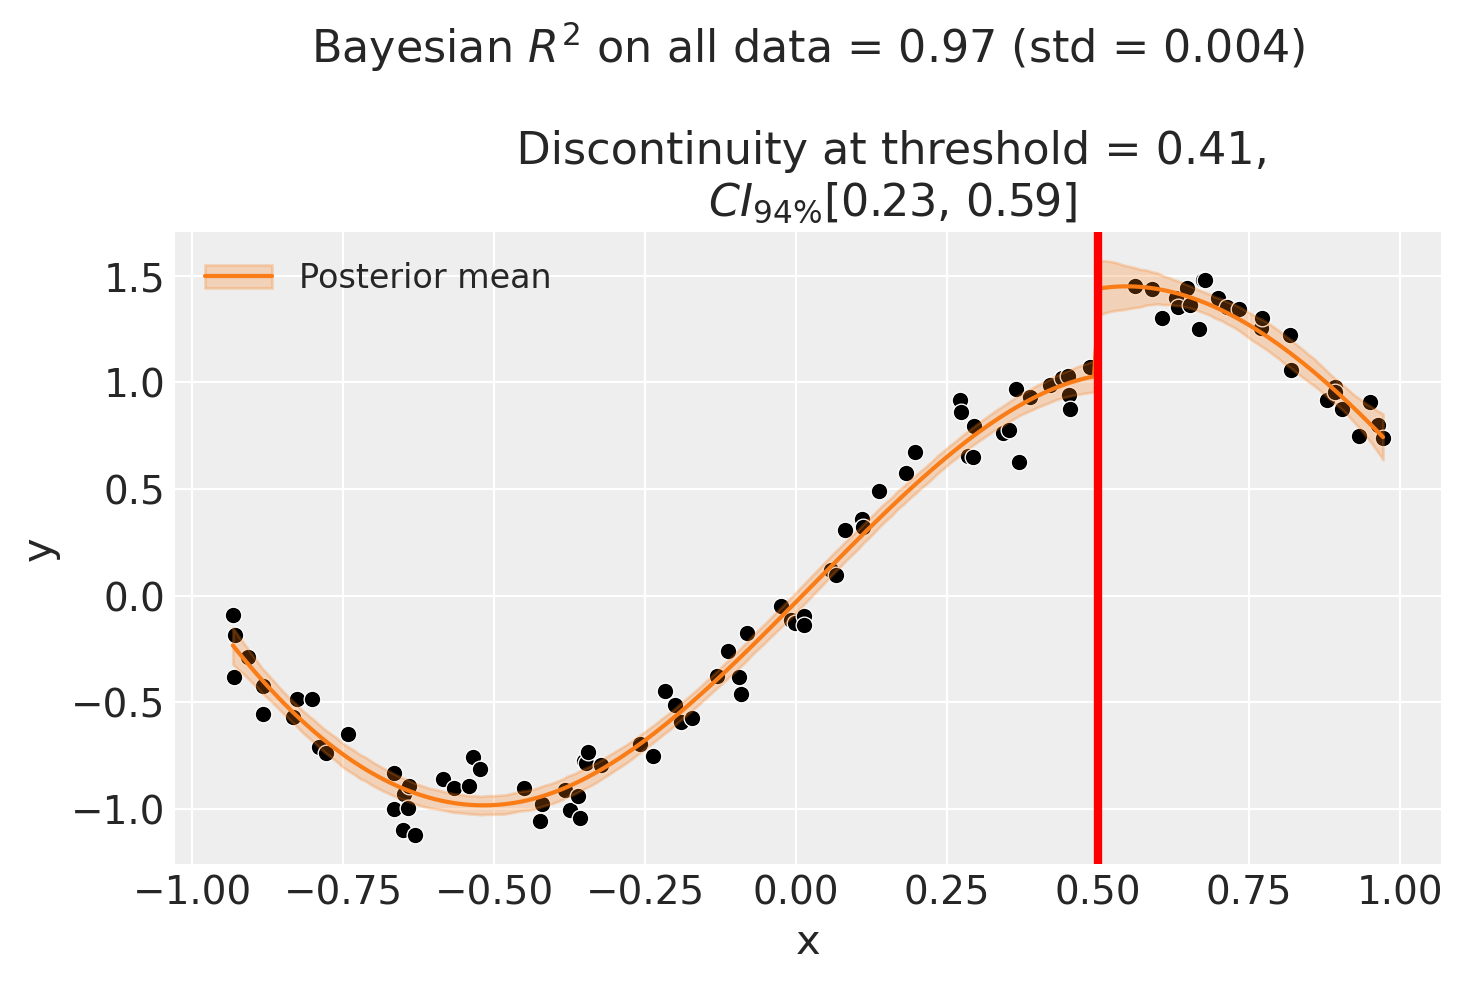

In [7]:
result = cp.RegressionDiscontinuity(
    df,
    formula="y ~ 1 + bs(x, df=6) + treated",
    model=cp.pymc_models.LinearRegression(sample_kwargs={"random_seed": seed}),
    treatment_threshold=0.5,
)

fig, ax = result.plot()

As with all of the models in this notebook, we can ask for a summary of the model coefficients.

In [8]:
result.summary()

Difference in Differences experiment
Formula: y ~ 1 + bs(x, df=6) + treated
Running variable: x
Threshold on running variable: 0.5

Results:
Discontinuity at threshold = 0.41$CI_{94\%}$[0.23, 0.59]


Model coefficients:
    Intercept        -0.23, 94% HDI [-0.32, -0.15]
    treated[T.True]  0.41, 94% HDI [0.23, 0.59]
    bs(x, df=6)[0]   -0.59, 94% HDI [-0.78, -0.41]
    bs(x, df=6)[1]   -1.1, 94% HDI [-1.2, -0.94]
    bs(x, df=6)[2]   0.28, 94% HDI [0.13, 0.43]
    bs(x, df=6)[3]   1.7, 94% HDI [1.5, 1.8]
    bs(x, df=6)[4]   1, 94% HDI [0.66, 1.4]
    bs(x, df=6)[5]   0.57, 94% HDI [0.37, 0.76]
    sigma            0.1, 94% HDI [0.089, 0.12]
